In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('./winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [7]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [15]:
def audit_negative(df: pd.DataFrame):
    """
    데이터는 수정하지 않음.
    수치형 컬럼에서 0 미만(<0) 값만 탐지.

    Returns
    -------
    summary : pd.DataFrame
        컬럼별 음수 개수/비율, 최솟값, 음수 여부 플래그
    bad_rows_df : pd.DataFrame
        하나라도 음수(<0)가 있는 행만 추린 뷰(원본 컬럼 유지 원하면 df.loc[...]로 바꿔도 됨)
    idx_by_col : dict[str, list]
        컬럼별 음수(<0) 발생 행 인덱스 목록
    neg_mask : pd.DataFrame[bool]
        수치형 컬럼 기준의 음수 마스크(후속 필터링에 활용)
    """
    # 1) 수치형 컬럼 선택
    num_cols = df.select_dtypes(include="number").columns.tolist()
    if not num_cols:
        raise ValueError("수치형 컬럼이 없습니다. df의 dtype을 확인하세요.")
    num_df = df[num_cols]

    # 2) 음수(<0) 마스크
    neg_mask = num_df.lt(0)

    # 3) 컬럼별 요약(개수, 비율, 최솟값)
    total = len(df)
    summary = pd.DataFrame({
        "negatives": neg_mask.sum(),
        "neg_rate(%)": (neg_mask.sum() / total * 100).round(2),
        "min_value": num_df.min()
    })
    summary["has_negative"] = summary["min_value"] < 0
    summary = summary.sort_values("negatives", ascending=False)

    # 4) 음수가 하나라도 있는 행만 추출(수치형만 보고 싶으면 num_cols, 전체 보고 싶으면 df.columns)
    bad_rows_idx = neg_mask.any(axis=1)
    bad_rows_df  = df.loc[bad_rows_idx, num_cols].copy()

    # 5) 컬럼별 음수 발생 인덱스
    idx_by_col = {c: df.index[neg_mask[c]].tolist() for c in num_cols if neg_mask[c].any()}

    return summary, bad_rows_df, idx_by_col, neg_mask


# =========================
# 사용 예시
# =========================
summary, bad_rows_df, idx_by_col, neg_mask = audit_negative(df)

print("=== 컬럼별 음수(<0) 요약 ===")
print(summary)

print("\n=== 음수가 하나라도 있는 행 (미리보기, 상위 20개) ===")
print(bad_rows_df.head(20))

# 특정 컬럼의 음수 위치 확인 예시
# print(idx_by_col.get("fixed acidity", []))

# (선택) 음수 행만 CSV로 저장
# bad_rows_df.to_csv("rows_with_negative_values.csv", index=True, encoding="utf-8-sig")

# (선택) 원본 df에서 음수 행만 따로 보고 싶을 때
# df_neg = df.loc[neg_mask.any(axis=1)]

=== 컬럼별 음수(<0) 요약 ===
                      negatives  neg_rate(%)  min_value  has_negative
fixed acidity                 0          0.0    4.60000         False
volatile acidity              0          0.0    0.12000         False
citric acid                   0          0.0    0.00000         False
residual sugar                0          0.0    0.90000         False
chlorides                     0          0.0    0.01200         False
free sulfur dioxide           0          0.0    1.00000         False
total sulfur dioxide          0          0.0    6.00000         False
density                       0          0.0    0.99007         False
pH                            0          0.0    2.74000         False
sulphates                     0          0.0    0.33000         False
alcohol                       0          0.0    8.40000         False
quality                       0          0.0    3.00000         False

=== 음수가 하나라도 있는 행 (미리보기, 상위 20개) ===
Empty DataFrame
Columns: [fixe

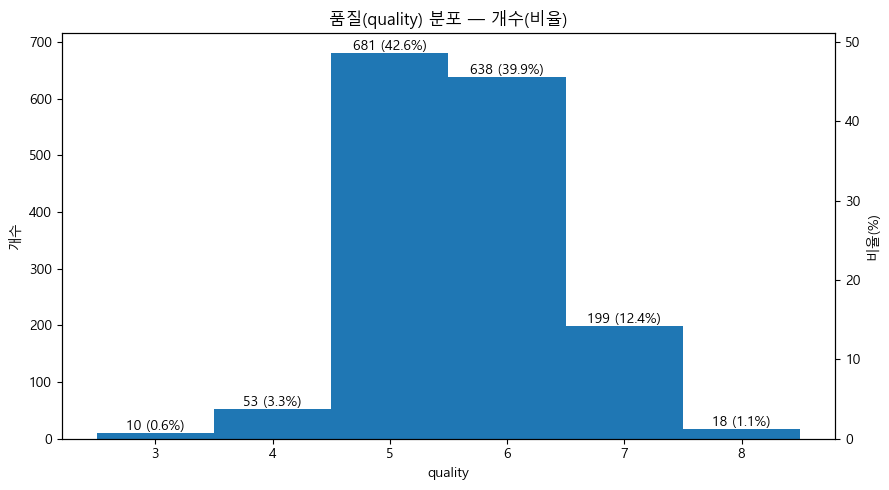

In [19]:
# 특성 살펴보기 (품질 분포, 히스토그램)
# (Windows 한글 폰트; 없으면 기본 폰트로 표시됩니다)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2) 정수 중심 bin 설정
qmin, qmax = int(np.floor(q.min())), int(np.ceil(q.max()))
bins = np.arange(qmin - 0.5, qmax + 1.5, 1)

# 3) 히스토그램 데이터 계산
counts, edges = np.histogram(q, bins=bins)
total = counts.sum()
rates = (counts / total * 100.0) if total > 0 else np.zeros_like(counts, dtype=float)
centers = (edges[:-1] + edges[1:]) / 2

# 4) 단일 차트 그리기 (색상 지정하지 않음)
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(centers, counts, width=1.0, align="center")  # 기본 색상 사용

# 5) 막대 라벨: "개수(비율%)"
for x, c, r in zip(centers, counts, rates):
    if c > 0:
        ax.text(x, c, f"{int(c)} ({r:.1f}%)", ha="center", va="bottom")

# 6) 축/제목
ax.set_title("품질(quality) 분포 — 개수(비율)")
ax.set_xlabel("quality")
ax.set_ylabel("개수")
ax.set_xticks(range(qmin, qmax + 1))

# 7) 오른쪽 y축(%) 라인 추가
ax2 = ax.twinx()
# ax2.plot(centers, rates, marker="o")  # 기본 색상 사용
ax2.set_ylabel("비율(%)")
ax2.set_ylim(0, rates.max() * 1.2 if rates.max() > 0 else 1)

plt.tight_layout()
plt.show()



In [23]:
df['quality']

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

상관행렬 저장: corr_matrix_pearson.csv

=== 상관행렬(요약 5x5) ===
                  quality  alcohol  volatile acidity  sulphates  citric acid
quality              1.00     0.48             -0.39       0.25         0.23
alcohol              0.48     1.00             -0.20       0.09         0.11
volatile acidity    -0.39    -0.20              1.00      -0.26        -0.55
sulphates            0.25     0.09             -0.26       1.00         0.31
citric acid          0.23     0.11             -0.55       0.31         1.00


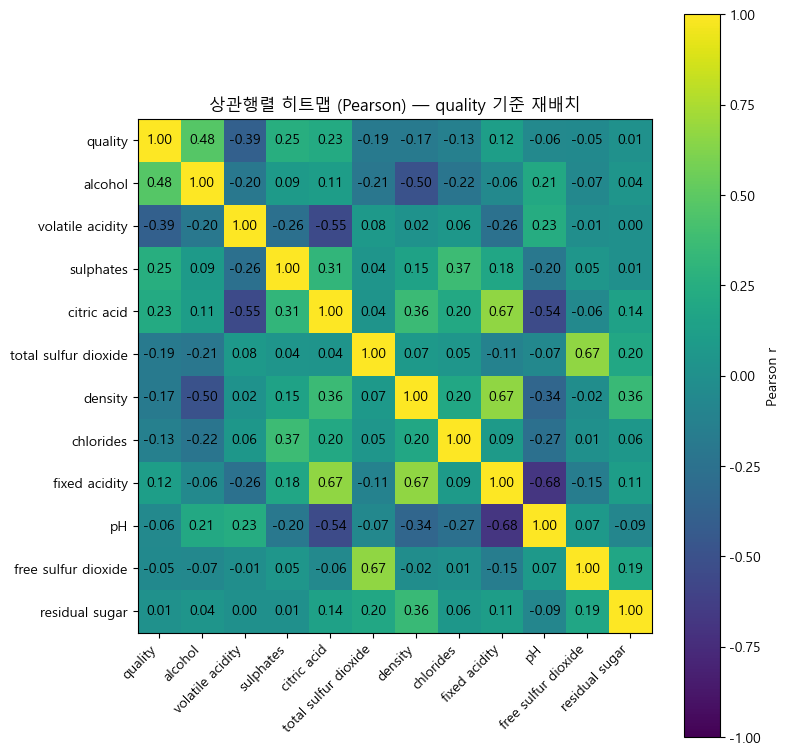

In [27]:
# 품질과의 상관관계(히트맵) / 품질에 영향을 많이 주는 특성들 시각화

# -*- coding: utf-8 -*-
# 정사각 상관행렬(피어슨) 히트맵 + 'quality' 기준 재배치(버그 수정 버전)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (Windows 한글 폰트; 시스템에 없으면 기본 폰트로 표시됩니다)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 0) 데이터 준비: 세션에 df 없으면 CSV 자동 로드
try:
    _df = df.copy()
except NameError:
    path = "winequality-red.csv"  # 필요시 절대경로로 교체
    with open(path, "r", encoding="utf-8") as f:
        first_line = f.readline()
    delim = ";" if first_line.count(";") > first_line.count(",") else ","
    _df = pd.read_csv(path, sep=delim)

# 1) quality 존재/수치형 보장
if "quality" not in _df.columns:
    raise KeyError(f"'quality' 컬럼이 없습니다. 실제 컬럼들: {list(_df.columns)}")

# quality를 숫자로 강제(문자형으로 읽힌 경우 대비)
_df["quality"] = pd.to_numeric(_df["quality"], errors="coerce")

# 2) 수치형만 상관행렬(피어슨)
num_cols = _df.select_dtypes(include="number").columns.tolist()
corr = _df[num_cols].corr(method="pearson")

# 3) 'quality' 기준 재배치 (수정된 안전 버전)
if "quality" in corr.columns:
    order = (corr["quality"]
             .drop("quality")              # 자기 자신 제외
             .abs().sort_values(ascending=False).index.tolist())
    order = ["quality"] + order
    corr = corr.loc[order, order]
else:
    raise KeyError("'quality'가 상관행렬 컬럼에 없습니다. dtype/결측을 확인하세요.")

# 4) 상관행렬 저장(옵션)
corr.to_csv("corr_matrix_pearson.csv", encoding="utf-8-sig")
print("상관행렬 저장: corr_matrix_pearson.csv")
print("\n=== 상관행렬(요약 5x5) ===")
print(corr.iloc[:5, :5].round(2))

# 5) 정사각 히트맵 (단일 플롯)
labels = corr.columns.tolist()
n = len(labels)
fig_size = max(8, 0.6 * n)  # 변수 수에 따른 동적 크기
fig, ax = plt.subplots(figsize=(fig_size, fig_size))

im = ax.imshow(corr.values, vmin=-1, vmax=1)  # 색상 지정 없음(기본 cmap)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
ax.set_title("상관행렬 히트맵 (Pearson) — quality 기준 재배치")

# 셀 값 주석(복잡하면 아래 블록을 주석 처리)
for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{corr.iat[i, j]:.2f}", ha="center", va="center")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Pearson r")

plt.tight_layout()
plt.show()


In [ ]:
# 추가로 qualitiy_labels 컬럼 생성 -> 0~5 : 0 / 6~7 : 1/ 8~10: 2

In [29]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [30]:
# 훈련 테스트 셋 나누기

# 데이터셋 분리
X = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']].to_numpy()
y = df['quality'].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
len(X_train)

1199

In [ ]:
# KNN회귀로 와인 품질 예측

from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier()

kn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [32]:
kn.score(X_train, y_train)

0.6705587989991659

In [ ]:
# 선형회귀로 와인 품질 예측 (훈련셋/테스트셋의 점수를 높여보자)

In [ ]:
# Ridge, Lasso로 규제해가며 예측